## T4 ISBFK Yang, Y., Cai, J., Yang, H., Li, Y., & Zhao, X. (2022). ISBFK-means: A new clustering algorithm based on influence space. Expert Systems With Applications, 201, 117018. https://doi.org/10.1016/j.eswa.2022.117018

# 17/12/2024

C:\Users\psbis\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette Score: -0.168
Davies-Bouldin Index: 2.097
S/DB Ratio: -0.08
Adjusted Rand Index (ARI): -0.035
F1 Score: 0.139
Hubness Mean: 5.0
Hubness Std Dev: 2.196
Number of Noise Points: 189
Percentage of Noise Points: 96.92%
AUC Value: 0.274


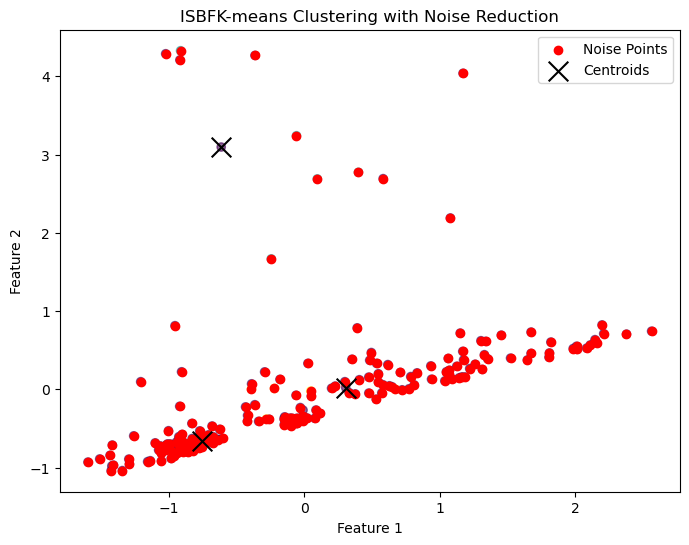

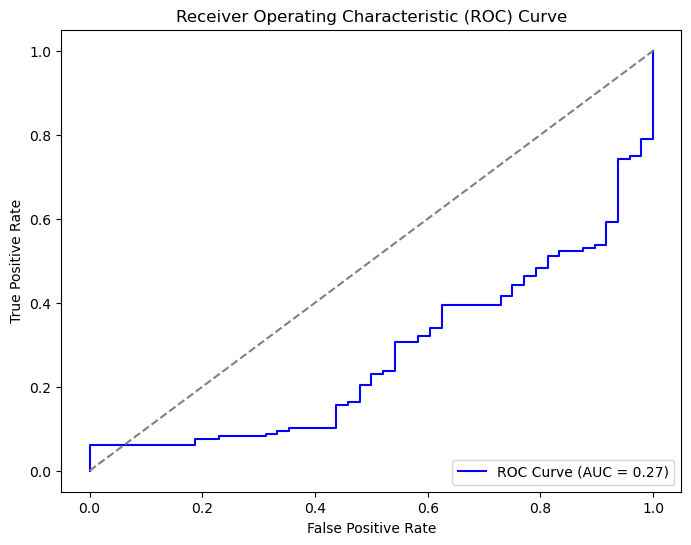

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score, davies_bouldin_score, roc_curve, auc, 
    adjusted_rand_score, f1_score
)
from sklearn.neighbors import NearestNeighbors

# Load and preprocess the dataset
# Load and preprocess the dataset
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\pima.csv"
file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\parkinsons.csv"
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\heart.csv"
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\hepatitis.csv"
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\ionosphere.csv"
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\anemia.csv"
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\syn1.csv"
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\syn2.csv"

data = pd.read_csv(file_path)

X = data.iloc[:, :-1]
y_true = data.iloc[:, -1]  # Ground truth for evaluation

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Parameters
M = 5  # Number of nearest neighbors for influence space
K = 3  # Number of clusters

# Function to calculate influence space
def calculate_influence_space(X, M):
    NN_M = []  # Nearest neighbors
    RNN_M = []  # Reverse nearest neighbors
    influence_space = []

    for i, x in enumerate(X):
        distances = np.linalg.norm(X - x, axis=1)
        sorted_indices = np.argsort(distances)
        NN_M.append(sorted_indices[1:M+1] if len(sorted_indices) > M else sorted_indices[1:])  # Exclude self
        
    for i in range(len(X)):
        reverse_neighbors = [j for j in range(len(X)) if i in NN_M[j]]
        RNN_M.append(reverse_neighbors)
        intersected_neighbors = np.intersect1d(NN_M[i], reverse_neighbors)
        influence_space.append(intersected_neighbors)

    return influence_space

# Determine influence space
influence_space = calculate_influence_space(X_scaled, M)

# Sort points by influence space size
influence_sizes = [len(ispace) for ispace in influence_space]
sorted_indices = np.argsort(influence_sizes)[::-1]

# Mark points for noise reduction
n = len(X_scaled)
noise_indices = sorted_indices[int(np.sqrt(n)/2):]  # Last sqrt(n)/2 as noise
representative_indices = [i for i in sorted_indices if i not in noise_indices]

# Create representative dataset
representative_points = X_scaled[representative_indices]

# Apply K-means clustering on representative points
kmeans = KMeans(n_clusters=K)
kmeans.fit(representative_points)
representative_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Map back to original data
original_labels = np.zeros(n, dtype=int)
for i, rep_index in enumerate(representative_indices):
    for index in influence_space[rep_index]:
        original_labels[index] = representative_labels[i]

# Metrics
silhouette = silhouette_score(X_scaled, original_labels)
davies_bouldin = davies_bouldin_score(X_scaled, original_labels)
s_db_ratio = silhouette / davies_bouldin if davies_bouldin != 0 else None

# Adjusted Rand Index (ARI)
ari = adjusted_rand_score(y_true, original_labels)

# F1 Score
f1 = f1_score(y_true, original_labels, average='weighted')

# Hubness Score
def hubness_score(X, k=5):
    nbrs = NearestNeighbors(n_neighbors=k).fit(X)
    indices = nbrs.kneighbors(X, return_distance=False)
    hubness = np.bincount(indices.flatten(), minlength=len(X))
    return np.mean(hubness), np.std(hubness)

hubness_mean, hubness_std = hubness_score(X_scaled, k=5)

# Calculate AUC
predicted_scores = np.linalg.norm(X_scaled - centroids[original_labels], axis=1)
fpr, tpr, _ = roc_curve(y_true, predicted_scores)
roc_auc = auc(fpr, tpr)

# Print Metrics
print("Silhouette Score:", np.round(silhouette, 3))
print("Davies-Bouldin Index:", np.round(davies_bouldin, 3))
print("S/DB Ratio:", np.round(s_db_ratio, 3))
print("Adjusted Rand Index (ARI):", np.round(ari, 3))
print("F1 Score:", np.round(f1, 3))
print("Hubness Mean:", np.round(hubness_mean, 3))
print("Hubness Std Dev:", np.round(hubness_std, 3))
print("Number of Noise Points:", len(noise_indices))
print(f"Percentage of Noise Points: {len(noise_indices)/n*100:.2f}%")
print("AUC Value:", np.round(roc_auc, 3))

# Visualizations
# Highlight Detected Noise Points
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=original_labels, cmap='viridis', alpha=0.6)
plt.scatter(X_scaled[noise_indices, 0], X_scaled[noise_indices, 1], c='red', label='Noise Points')
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='x', s=200, label='Centroids')
plt.title('ISBFK-means Clustering with Noise Reduction')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

# ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()
